# Import Package

In [1]:
import datetime
import gc
import os

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd

# Global Definitions

In [2]:
WINDOW_LENGTH = 28
path_ERA5 = "/work/b08209033/DATA/IndianMonsoon/ERA5"
path_TempestExtremes = "/work/b08209033/DATA/IndianMonsoon/TempestExtremes"


def moving_average(array, axis=0):
    weighting = np.ones(WINDOW_LENGTH) / WINDOW_LENGTH
    tmp = np.apply_along_axis(
        lambda m: np.convolve(m, weighting, mode="same"),
        axis=axis,
        arr=array,
    )
    return tmp

# Zonal Wind Shear & Monsoon Onset Date (two regions) 

In [3]:
def get_ZWS(fname):
    """
    Variable Definitions
    zws_convolution : monsoon index, defined by zonal wind shear between two regions, refered to BIN WANG (2001)
    monsoon_onset_date : the date first time zws_convolution is larger than 0 for every year
    """
    # data = nc.Dataset("/work/b08209033/DATA/ERA5/u/u_850_alltime.nc")
    dataset = nc.Dataset(os.path.join(path_ERA5, fname))
    lon = dataset["lon"][:]
    lat = dataset["lat"][:]
    lons, lats = np.meshgrid(lon, lat)
    pressure = dataset["plev"][:]
    plevel = np.where(np.absolute(pressure - 850 * 100) < 1e-3)[0][0]
    u = dataset["u"][:, plevel, :, :]
    print(u.shape)
    print(pressure[plevel])
    print(lon[0], lon[-1])
    print(lat[0], lat[-1])

    u_south_region = u[:, (lat > 5) & (lat < 15), :][:, :, (lon > 40) & (lon < 80)]
    u_north_region = u[:, (lat > 20) & (lat < 30), :][:, :, (lon > 70) & (lon < 90)]

    u_south_region = np.mean(u_south_region, axis=(1, 2))
    u_north_region = np.mean(u_north_region, axis=(1, 2))

    zws_raw = u_south_region - u_north_region
    zws_convolution = moving_average(zws_raw, axis=0)
    zws_convolution_grad = np.gradient(zws_convolution)

    zws_raw = np.reshape(zws_raw, (-1, 365))
    zws_convolution = np.reshape(zws_convolution, (-1, 365))
    zws_convolution_grad = np.reshape(zws_convolution_grad, (-1, 365))

    return zws_raw, zws_convolution, zws_convolution_grad

In [4]:
zws_raw, zws_convolution, zws_convolution_grad = get_ZWS("u.nc")
monsoon_onset_date = dict(
    zip(np.arange(1979, 2022).tolist(), np.argmax(zws_convolution > 0, axis=1).tolist())
)
monsoon_onset_date = dict(sorted(monsoon_onset_date.items(), key=lambda item: item[1]))

(15695, 360, 576)
85000.0
0.3125 359.6875
-89.75 89.75


# Low Pressure Occurrence (counter per timestep)

In [5]:
def get_occurrence(fname):
    """
    Variable Definitions
        occurrence : for every timestep, the number of POSSIBLE low pressure system (isolated)
    Note that this method is inaccurate (multiple-count)
    """
    dataframe = pd.read_csv(
        os.path.join(path_TempestExtremes, fname),
        sep="\t",
        on_bad_lines="skip",
        header=None,
    )
    dataframe.columns = ["Year", "Month", "Day", "Occurrence", "Time"]
    dataframe = dataframe.astype(int)

    #
    occurrence_raw = dataframe[dataframe.columns[3]].to_numpy()
    occurrence_convolution = moving_average(occurrence_raw, axis=0)
    occurrence_raw = occurrence_raw.reshape(-1, 365)
    occurrence_convolution = occurrence_convolution.reshape(-1, 365)
    return dataframe, occurrence_raw, occurrence_convolution

In [6]:
_, occurrence_raw, occurrence_convolution = get_occurrence(
    "TropicalCycloneCount_925.csv"
)

Text(0.5, 0.98, 'Variable Charts\n Running Window = 28 (day)\n')

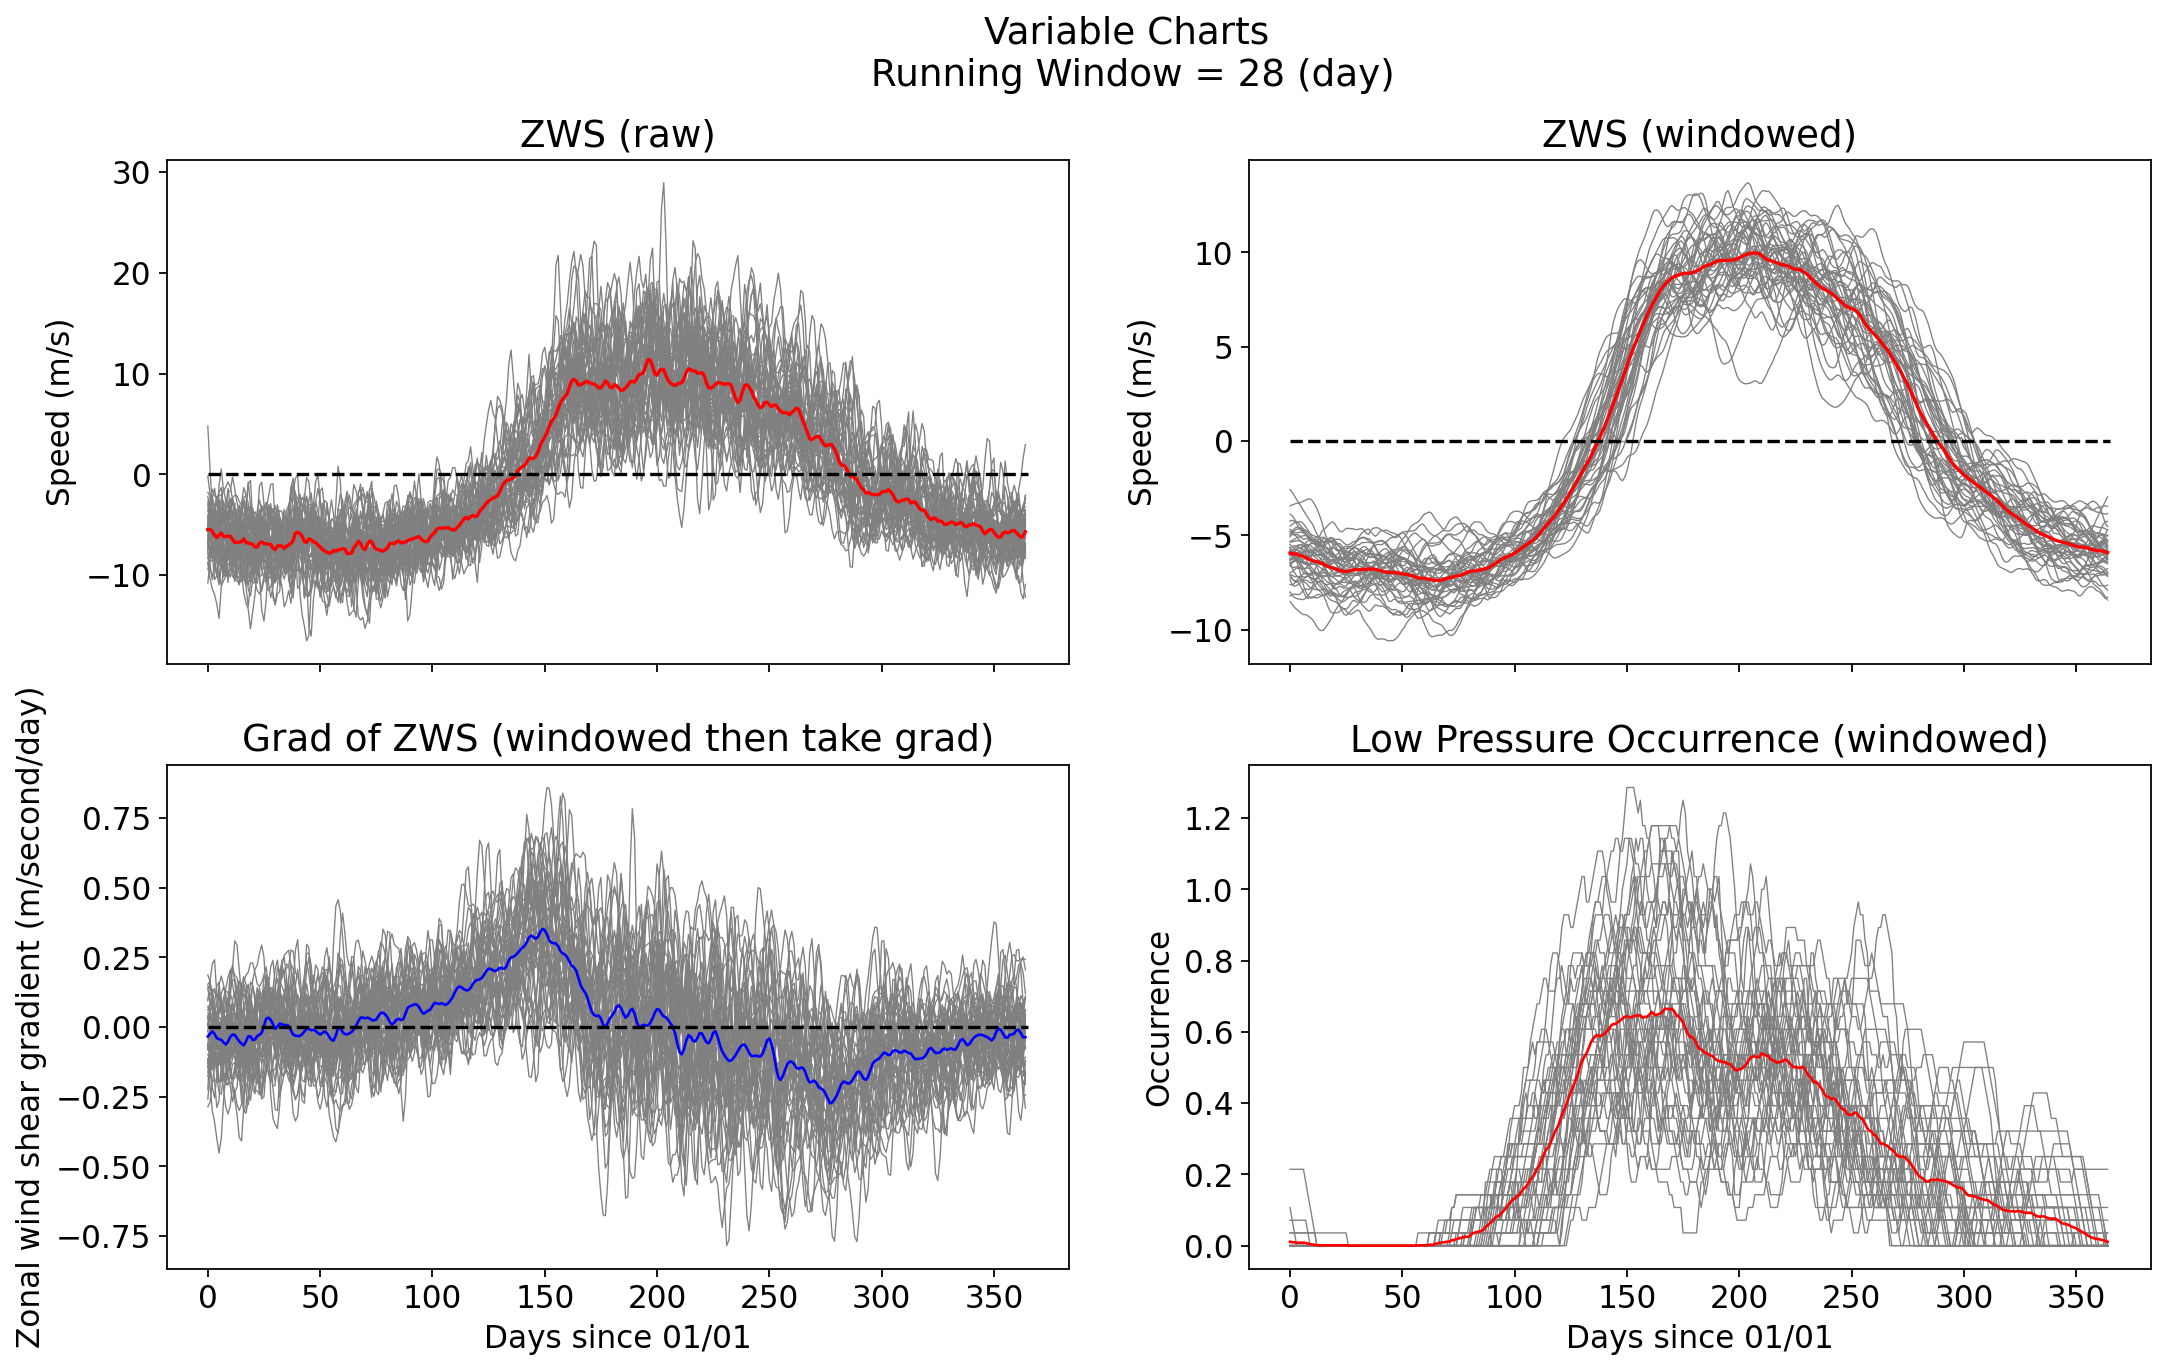

In [7]:
# figure
plt.rcParams.update({"font.size": 14})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9), dpi=160, sharex=True)
# plt.rcParams.update({"font.size": 14})

# Upper Left
for i in range(43):
    axes[0, 0].plot(zws_raw[i], color="gray", lw=0.6)
axes[0, 0].plot(np.mean(zws_raw, axis=0), color="red")
axes[0, 0].plot([0, 365], [0, 0], "k--")
axes[0, 0].set_ylabel("Speed (m/s)")
axes[0, 0].set_title("ZWS (raw)")
# Upper Right
for i in range(43):
    axes[0, 1].plot(zws_convolution[i], color="gray", lw=0.6)
axes[0, 1].plot(np.mean(zws_convolution, axis=0), color="red")
axes[0, 1].plot([0, 365], [0, 0], "k--")
axes[0, 1].set_ylabel("Speed (m/s)")
axes[0, 1].set_title("ZWS (windowed)")
# Lower Left
for i in range(43):
    axes[1, 0].plot(zws_convolution_grad[i], color="gray", lw=0.6)
axes[1, 0].plot(np.mean(zws_convolution_grad, axis=0), color="b", lw=1.2)
axes[1, 0].plot([0, 365], [0, 0], "k--")
axes[1, 0].set_xlabel("Days since 01/01")
axes[1, 0].set_ylabel("Zonal wind shear gradient (m/second/day)")
axes[1, 0].set_title("Grad of ZWS (windowed then take grad)")
# Lower Right
for i in range(43):
    axes[1, 1].plot(occurrence_convolution[i], color="gray", lw=0.6)
axes[1, 1].plot(np.mean(occurrence_convolution, axis=0), color="r", lw=1.2)
axes[1, 1].set_xlabel("Days since 01/01")
axes[1, 1].set_ylabel("Occurrence")
axes[1, 1].set_title("Low Pressure Occurrence (windowed)")
#
fig.suptitle(f"Variable Charts\n Running Window = {WINDOW_LENGTH} (day)\n")

# Streamfunction (yz plane)

## Unitest

In [8]:
def UNITEST_streamfunction_global(fname):
    """
    https://derekyuntao.github.io/jekyll-clean-dark/2021/02/mass-stream-func/
    """
    dataset = nc.Dataset(os.path.join(path_ERA5, fname))
    pressure = dataset["plev"][::-1]
    thickness = np.diff(np.insert(pressure, 0, 0))
    lat = dataset["lat"][:]
    v_div = dataset["v"][:, ::-1, :, -1]
    print(np.insert(pressure, 0, 0))
    print(thickness)
    print(v_div.shape)

    #
    tmp = np.insert(v_div, 0, 0, axis=1)
    v_div_interp = (tmp[:, :-1, :] + tmp[:, 1:, :]) / 2
    weighting = 2 * np.pi * 6.371e6 * np.cos(np.deg2rad(lat)) / 9.81
    streamfunction = np.swapaxes(v_div_interp, 1, -1) * thickness
    streamfunction = np.cumsum(streamfunction, axis=-1)
    streamfunction = np.swapaxes(streamfunction, -1, 1) * weighting

    streamfunction_convolution = moving_average(streamfunction, axis=0)

    def animation_generator(sf):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=160)
        ax.set_xticks(np.linspace(-90, 90, 7))
        ax.set_yticks(np.linspace(pressure[0], pressure[-1], 4))

        def init():
            return None

        def run(index):
            ax.cla()
            ax.invert_yaxis()
            tmp = np.mean(sf[index * 5 :: 365], axis=0)
            ax.contourf(
                lat,
                pressure,
                tmp,
                levels=np.linspace(-5e10, 5e10, 8),
                extend="both",
                cmap="RdBu_r",
            )
            ax.contour(
                lat, pressure, tmp, levels=np.linspace(-5e10, 5e10, 8), colors="k"
            )
            ax.set_title(f"day {index*5}")
            return None

        ani = animation.FuncAnimation(
            fig, run, frames=int(365 / 5) + 1, interval=10, init_func=init
        )
        return ani

    # animation_object = animation_generator(streamfunction_convolution)
    # animation_object.save("animation.gif")
    return streamfunction, streamfunction_convolution


def UNITEST_streamfunction_regional(fname):
    """
    https://derekyuntao.github.io/jekyll-clean-dark/2021/02/mass-stream-func/
    """
    dataset = nc.Dataset(os.path.join(path_ERA5, fname))
    pressure = dataset["plev"][::-1]
    thickness = np.diff(np.insert(pressure, 0, 0))
    lon = dataset["lon"][:]
    lat = dataset["lat"][:]
    v_div = dataset["v"][:, ::-1, :, :]
    print(np.insert(pressure, 0, 0))
    print(thickness)
    print(v_div.shape)
    print(lon[0], lon[-1])
    print(lat[0], lat[-1])

    #
    tmp = np.mean(v_div, axis=-1)
    tmp = np.insert(tmp, 0, 0, axis=1)
    v_div_interp = (tmp[:, :-1, :] + tmp[:, 1:, :]) / 2
    weighting = np.deg2rad(lon[-1] - lon[0]) * 6.371e6 * np.cos(np.deg2rad(lat)) / 9.81
    streamfunction = np.swapaxes(v_div_interp, 1, -1) * thickness
    streamfunction = np.cumsum(streamfunction, axis=-1)
    streamfunction = np.swapaxes(streamfunction, -1, 1) * weighting

    streamfunction_convolution = moving_average(streamfunction, axis=0)

    def animation_generator(sf):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 9), dpi=160)
        ax.set_xticks(np.linspace(0, 30, 7))
        ax.set_yticks(np.linspace(pressure[0], pressure[-1], 4))

        def init():
            return None

        def run(index):
            ax.cla()
            ax.invert_yaxis()
            tmp = np.mean(sf[index * 5 :: 365], axis=0)
            ax.contourf(
                lat,
                pressure,
                tmp,
                levels=np.linspace(-5e10, 5e10, 8),
                extend="both",
                cmap="RdBu_r",
            )
            ax.contour(
                lat, pressure, tmp, levels=np.linspace(-5e10, 5e10, 8), colors="k"
            )
            ax.set_title(f"day {index*5}")
            return None

        ani = animation.FuncAnimation(
            fig, run, frames=int(365 / 5) + 1, interval=10, init_func=init
        )
        return ani

    # animation_object = animation_generator(streamfunction_convolution)
    # animation_object.save("animation.gif")
    return streamfunction, streamfunction_convolution


def get_streamfunction(fname):
    """
    https://derekyuntao.github.io/jekyll-clean-dark/2021/02/mass-stream-func/
    """
    dataset = nc.Dataset(os.path.join(path_ERA5, fname))
    pressure = dataset["plev"][::-1]
    thickness = np.diff(np.insert(pressure, 0, 0))
    lon = dataset["lon"][:]
    lat = dataset["lat"][:]
    v_div = dataset["v"][:, ::-1, :, :]
    print(np.insert(pressure, 0, 0))
    print(thickness)
    print(v_div.shape)
    print(lon[0], lon[-1])
    print(lat[0], lat[-1])

    #
    tmp = np.mean(v_div, axis=-1)
    tmp = np.insert(tmp, 0, 0, axis=1)
    v_div_interp = (tmp[:, :-1, :] + tmp[:, 1:, :]) / 2
    weighting = np.deg2rad(lon[-1] - lon[0]) * 6.371e6 * np.cos(np.deg2rad(lat)) / 9.81
    streamfunction = np.swapaxes(v_div_interp, 1, -1) * thickness
    streamfunction = np.cumsum(streamfunction, axis=-1)
    streamfunction = np.swapaxes(streamfunction, -1, 1) * weighting
    streamfunction_convolution = moving_average(streamfunction, axis=0)

    streamfunction = streamfunction.reshape(
        -1, 365, streamfunction.shape[1], streamfunction.shape[2]
    )
    streamfunction_convolution = streamfunction_convolution.reshape(
        -1,
        365,
        streamfunction_convolution.shape[1],
        streamfunction_convolution.shape[2],
    )

    return streamfunction, streamfunction_convolution, (pressure, lat)

In [9]:
# _, __ = UNITEST_streamfunction_global("zonavg_divergent_uv.nc")
# _, __ = UNITEST_streamfunction_regional("indian_divergent_uv.nc")
streamfunction_raw, streamfunction_convolution, streamfunction_grids = (
    get_streamfunction("indian_divergent_uv.nc")
)

[     0.  10000.  20000.  25000.  50000.  70000.  85000.  92500. 100000.]
[10000. 10000.  5000. 25000. 20000. 15000.  7500.  7500.]
(15695, 8, 50, 89)
45.0 100.0
0.25 24.75


## Cases (per timestep)

In [10]:
def streamfunction_cases_animation_generator(streamfunction, lat, pressure):
    fig, axes = plt.subplots(
        nrows=2, ncols=5, figsize=(32, 18), dpi=160, sharex=True, sharey=True
    )
    plt.rcParams.update({"font.size": 28})

    def init():
        return None

    def run(index):
        for (i, j), ax in np.ndenumerate(axes):
            ax.cla()
            match i:
                case 0:
                    ax.invert_yaxis()
                    tmp_year = list(monsoon_onset_date.keys())[j]
                    tmp_date = list(monsoon_onset_date.values())[j]
                case 1:
                    tmp_year = list(monsoon_onset_date.keys())[j - 5]
                    tmp_date = list(monsoon_onset_date.values())[j - 5]
            tmp = streamfunction[tmp_year - 1979, index + 100]
            ax.contourf(
                lat,
                pressure,
                tmp,
                levels=np.linspace(-2e10, 2e10, 16),
                extend="both",
                cmap="RdBu_r",
            )
            ax.contour(
                lat, pressure, tmp, levels=np.linspace(-2e10, 2e10, 16), colors="k"
            )

            ax.set_title(f"({tmp_year}, {tmp_date})")
        fig.suptitle(f"Calendar date = {index + 100}")
        return None

    ani = animation.FuncAnimation(fig, run, frames=70, interval=20, init_func=init)
    return ani


def streamfunction_composites_animation_generator(streamfunction, lat, pressure):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(16, 9), dpi=160, sharex=True, sharey=True
    )
    plt.rcParams.update({"font.size": 28})

    def init():
        return None

    def run(index):
        for (i,), ax in np.ndenumerate(axes):
            ax.cla()
            match i:
                case 0:
                    ax.invert_yaxis()
                    tmp = np.mean(
                        streamfunction[
                            np.array(list(monsoon_onset_date.keys())[:5]) - 1979,
                            index + 100,
                        ],
                        axis=0,
                    )
                    ax.set_title("Early onset")
                case 1:
                    tmp = np.mean(
                        streamfunction[
                            np.array(list(monsoon_onset_date.keys())[-5:]) - 1979,
                            index + 100,
                        ],
                        axis=0,
                    )
                    ax.set_title("Late onset")
            ax.contourf(
                lat,
                pressure,
                tmp,
                levels=np.linspace(-2e10, 2e10, 16),
                extend="both",
                cmap="RdBu_r",
            )
            ax.contour(
                lat, pressure, tmp, levels=np.linspace(-2e10, 2e10, 16), colors="k"
            )
        fig.suptitle(f"Calendar date = {index + 100}")
        return None

    ani = animation.FuncAnimation(fig, run, frames=70, interval=20, init_func=init)
    return ani

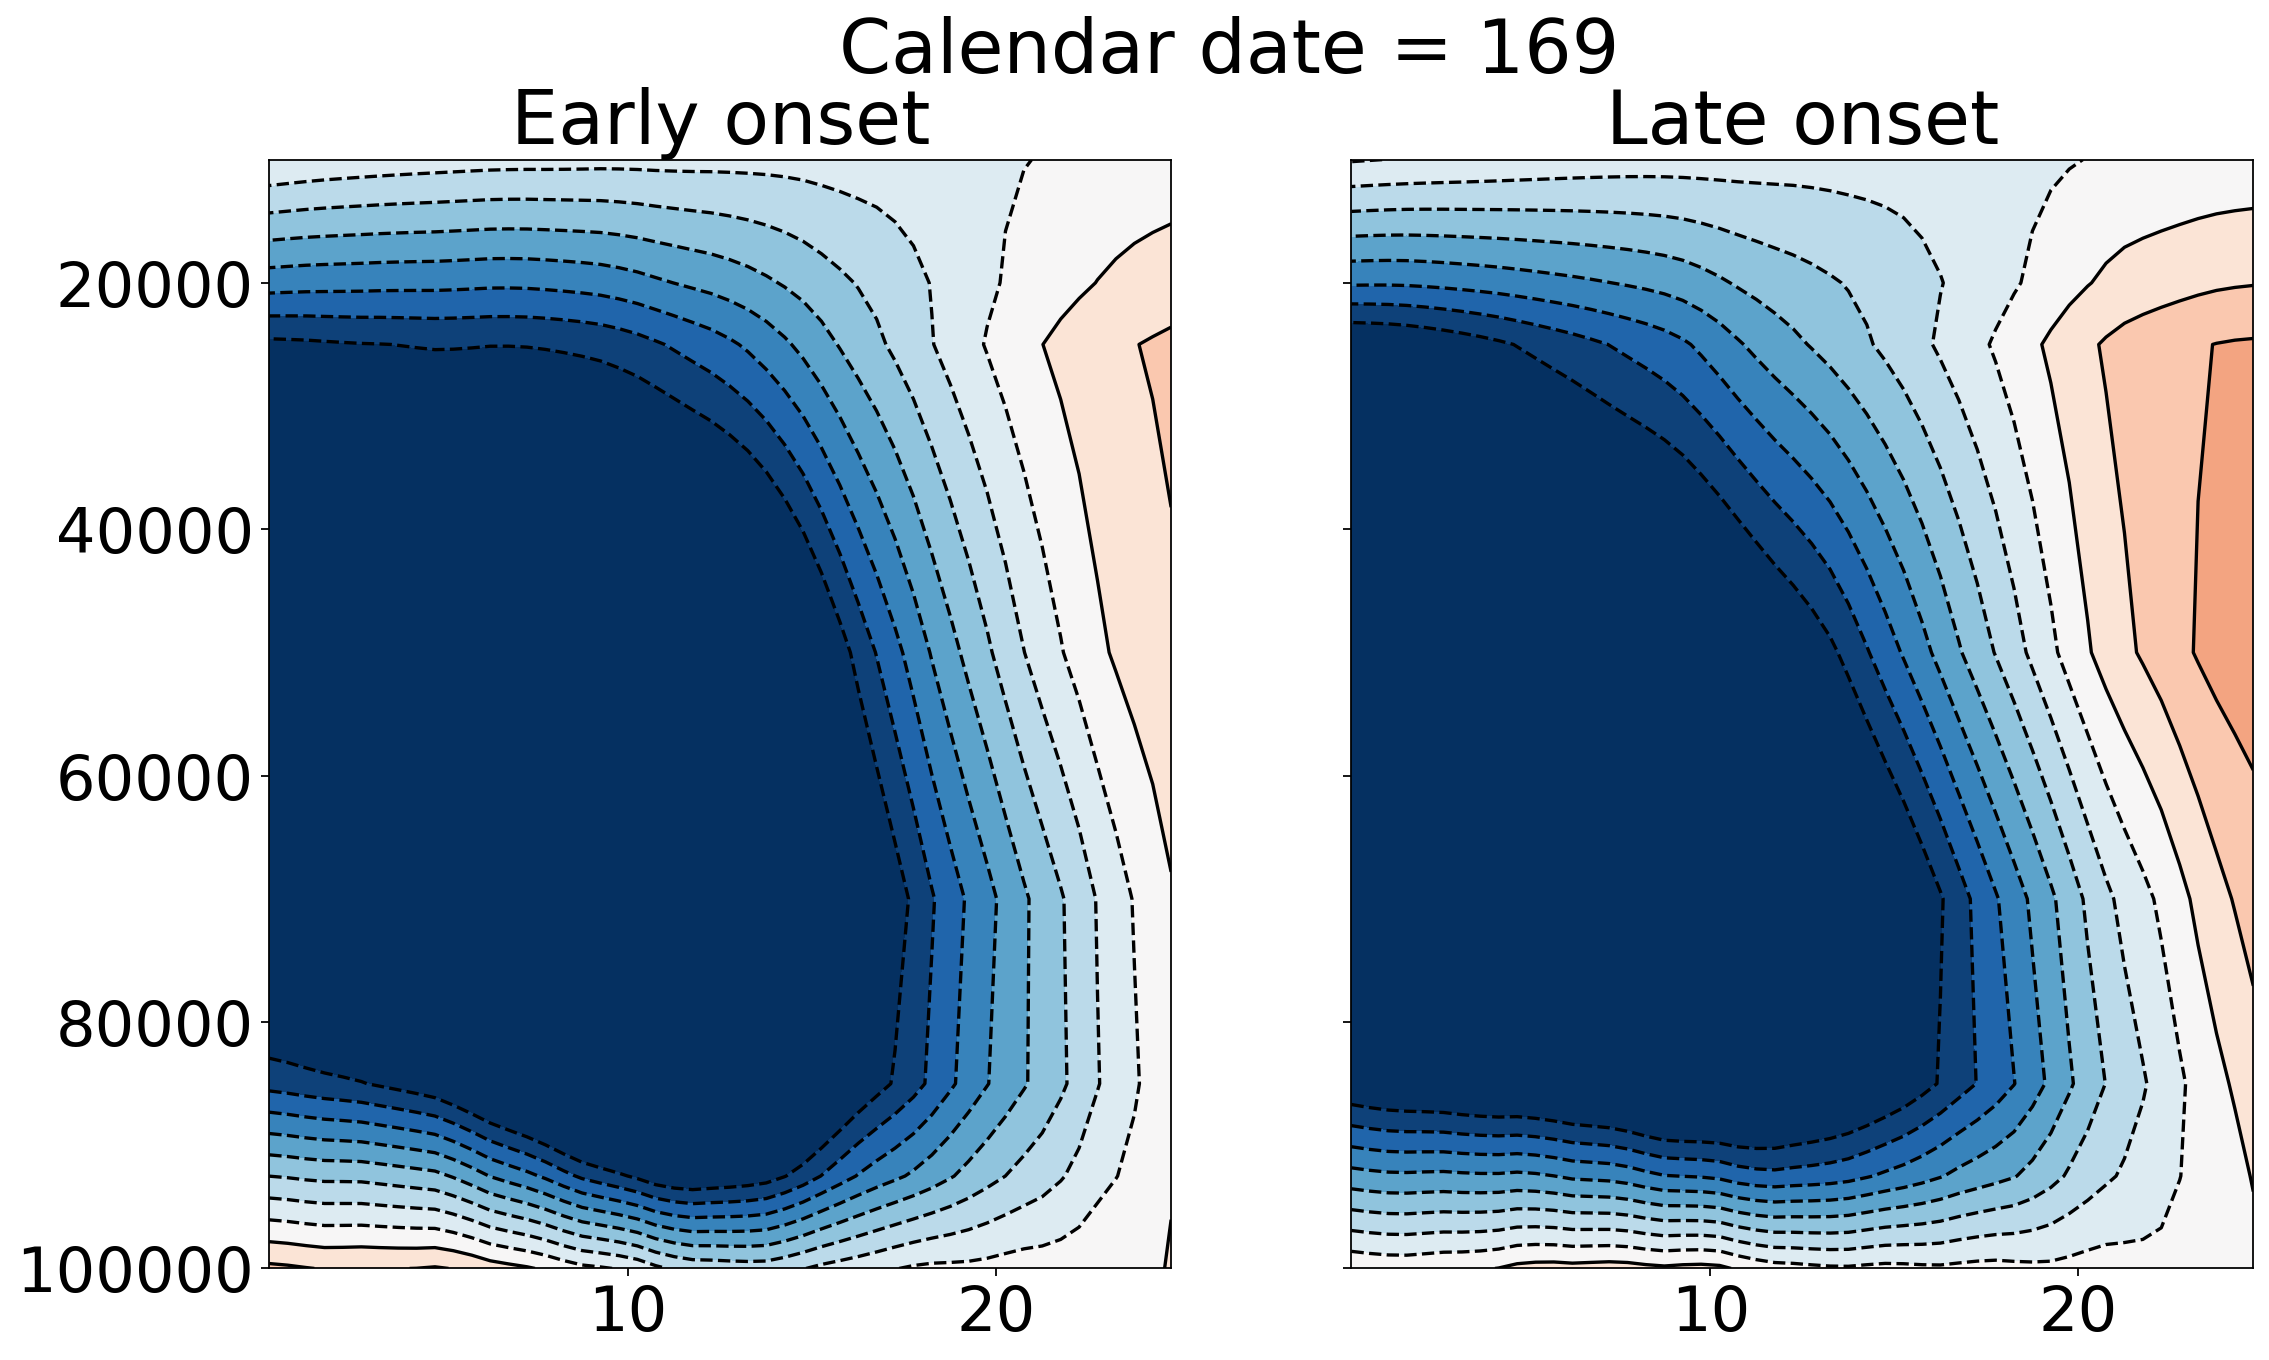

In [28]:
# animation_object = streamfunction_cases_animation_generator(
#     streamfunction_convolution, streamfunction_grids[1], streamfunction_grids[0]
# )
# animation_object.save("animation.gif")


animation_object = streamfunction_composites_animation_generator(
    streamfunction_convolution, streamfunction_grids[1], streamfunction_grids[0]
)
animation_object.save("animation.gif")

# Theta (yz plane)

In [12]:
def get_theta(fname):
    dataset = nc.Dataset(os.path.join(path_ERA5, fname))
    lon = dataset["lon"][:]
    lat = dataset["lat"][:]
    lons, lats = np.meshgrid(lon, lat)
    pressure = dataset["plev"][:]
    theta = dataset["theta"][:]
    print(theta.shape)
    print(pressure)

    theta_zonmean = np.mean(theta, axis=3)
    theta_convolution = moving_average(theta_zonmean, axis=0)

    theta_zonmean = theta_zonmean.reshape(
        -1, 365, theta_zonmean.shape[1], theta_zonmean.shape[2]
    )
    theta_convolution = theta_convolution.reshape(
        -1, 365, theta_convolution.shape[1], theta_convolution.shape[2]
    )

    return theta_zonmean, theta_convolution, (pressure, lat)

In [13]:
theta_raw, theta_convolution, _ = get_theta("indian_theta.nc")

(15695, 6, 50, 88)
[100000.  92500.  85000.  70000.  50000.  25000.]


In [14]:
def get_equiv_theta(fname):
    dataset = nc.Dataset(os.path.join(path_ERA5, fname))
    lon = dataset["lon"][:]
    lat = dataset["lat"][:]
    lons, lats = np.meshgrid(lon, lat)
    pressure = dataset["plev"][:]
    equiv_theta = dataset["equiv_theta"][:]
    print(equiv_theta.shape)
    print(pressure)

    equiv_theta_zonmean = np.mean(equiv_theta, axis=3)
    equiv_theta_convolution = moving_average(equiv_theta_zonmean, axis=0)

    equiv_theta_zonmean = equiv_theta_zonmean.reshape(
        -1, 365, equiv_theta_zonmean.shape[1], equiv_theta_zonmean.shape[2]
    )
    equiv_theta_convolution = equiv_theta_convolution.reshape(
        -1, 365, equiv_theta_convolution.shape[1], equiv_theta_convolution.shape[2]
    )

    return equiv_theta_zonmean, equiv_theta_convolution, (pressure, lat)

In [15]:
equiv_theta_raw, equiv_theta_convolution, equiv_theta_grids = get_equiv_theta(
    "indian_equiv_theta.nc"
)

(15695, 6, 50, 88)
[100000.  92500.  85000.  70000.  50000.  25000.]


In [16]:
def equiv_theta_cases_animation_generator(equiv_theta, lat, pressure):
    fig, axes = plt.subplots(
        nrows=2, ncols=5, figsize=(32, 18), dpi=160, sharex=True, sharey=True
    )
    plt.rcParams.update({"font.size": 28})

    def init():
        return None

    def run(index):
        for (i, j), ax in np.ndenumerate(axes):
            ax.cla()
            match i:
                case 0:
                    ax.invert_yaxis()
                    tmp_year = list(monsoon_onset_date.keys())[j]
                    tmp_date = list(monsoon_onset_date.values())[j]
                case 1:
                    tmp_year = list(monsoon_onset_date.keys())[j - 5]
                    tmp_date = list(monsoon_onset_date.values())[j - 5]
            tmp = equiv_theta[tmp_year - 1979, index + 100]
            ax.contourf(
                lat,
                pressure,
                tmp,
                levels=np.linspace(320, 350, 16),
                extend="both",
                cmap="RdBu_r",
            )
            ax.contour(lat, pressure, tmp, levels=np.linspace(320, 350, 16), colors="k")

            ax.set_title(f"({tmp_year}, {tmp_date})")
        fig.suptitle(f"Calendar date = {index + 100}")
        return None

    ani = animation.FuncAnimation(fig, run, frames=70, interval=20, init_func=init)
    return ani


def equiv_theta_composites_animation_generator(equiv_theta, lat, pressure):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(16, 9), dpi=160, sharex=True, sharey=True
    )
    plt.rcParams.update({"font.size": 28})

    def init():
        return None

    def run(index):
        for (i,), ax in np.ndenumerate(axes):
            ax.cla()
            match i:
                case 0:
                    ax.invert_yaxis()
                    tmp = np.mean(
                        equiv_theta[
                            np.array(list(monsoon_onset_date.keys())[:5]) - 1979,
                            index + 100,
                        ],
                        axis=0,
                    )
                    ax.set_title("Early onset")
                case 1:
                    tmp = np.mean(
                        equiv_theta[
                            np.array(list(monsoon_onset_date.keys())[-5:]) - 1979,
                            index + 100,
                        ],
                        axis=0,
                    )
                    ax.set_title("Late onset")
            ax.contourf(
                lat,
                pressure,
                tmp,
                levels=np.linspace(320, 350, 16),
                extend="both",
                cmap="RdBu_r",
            )
            ax.contour(lat, pressure, tmp, levels=np.linspace(320, 350, 16), colors="k")
        fig.suptitle(f"Calendar date = {index + 100}")
        return None

    ani = animation.FuncAnimation(fig, run, frames=70, interval=20, init_func=init)
    return ani

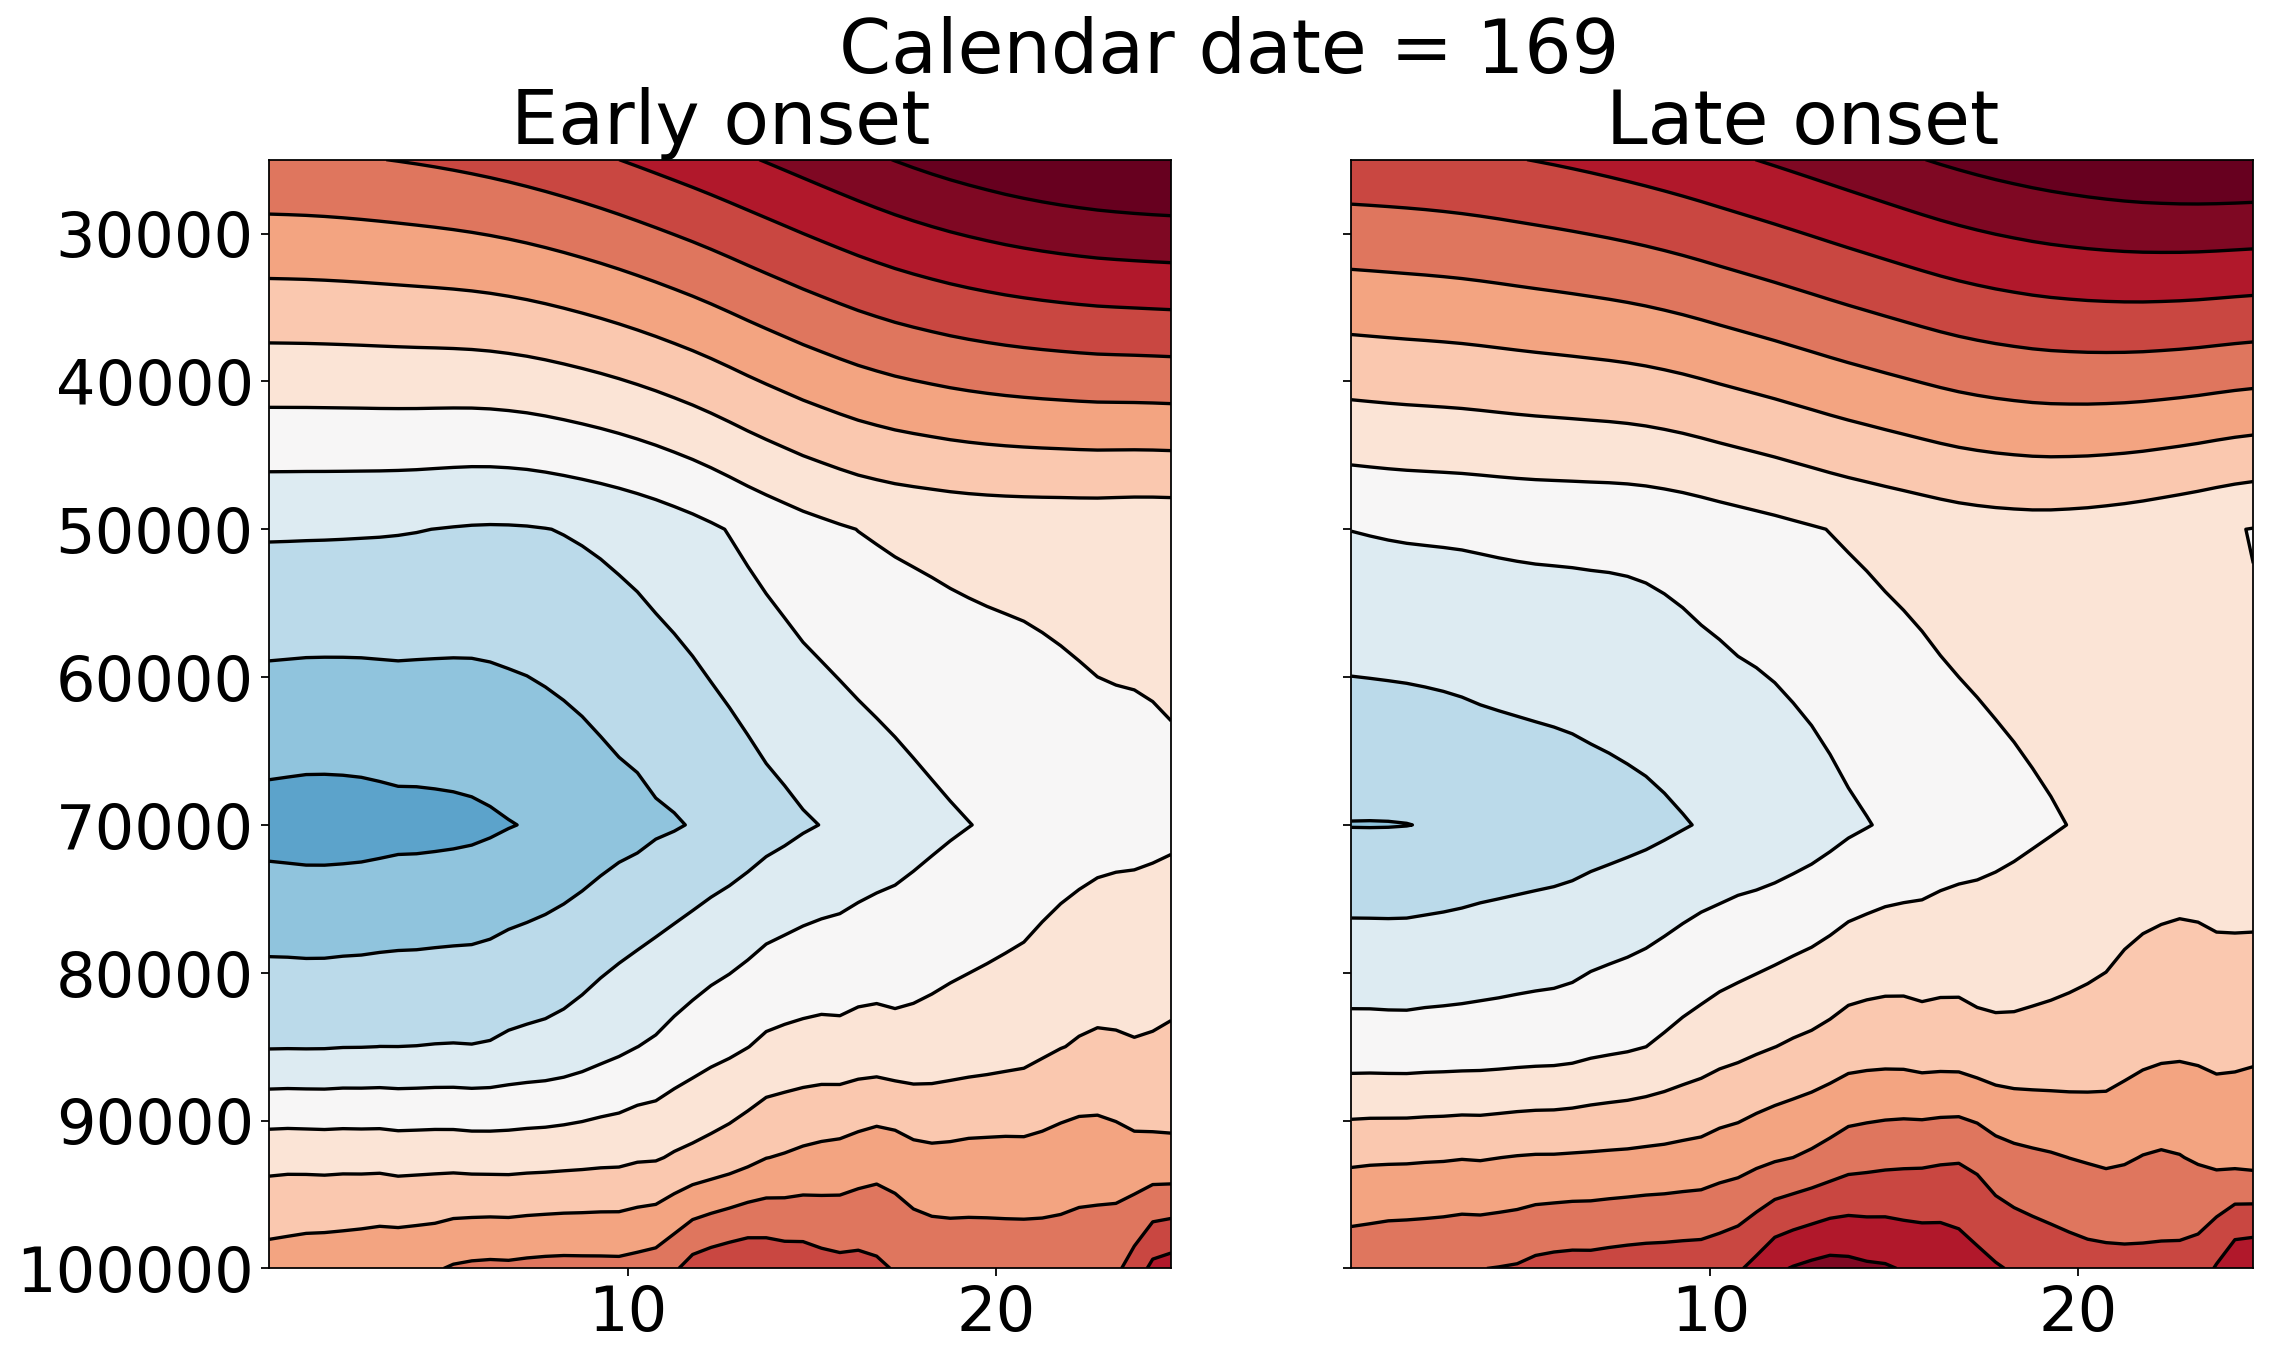

In [26]:
# animation_object = equiv_theta_cases_animation_generator(
#     equiv_theta_convolution, equiv_theta_grids[1], equiv_theta_grids[0]
# )
# animation_object.save("animation.gif")

animation_object = equiv_theta_composites_animation_generator(
    equiv_theta_convolution, equiv_theta_grids[1], equiv_theta_grids[0]
)
animation_object.save("animation.gif")

In [18]:
def equiv_theta_and_streamfunction_composites_animation_generator(
    equiv_theta, streamfunction, equiv_theta_grids, streamfunction_grids
):
    fig, ax = plt.subplots(
        nrows=1, ncols=1, figsize=(16, 9), dpi=160, sharex=True, sharey=True
    )
    plt.rcParams.update({"font.size": 28})

    def init():
        return None

    def run(index):
        ax.cla()
        ax.invert_yaxis()
        tmp1 = np.mean(
            equiv_theta[
                np.array(list(monsoon_onset_date.keys())[:5]) - 1979,
                index + 100,
            ],
            axis=0,
        )
        tmp2 = np.mean(
            streamfunction[
                np.array(list(monsoon_onset_date.keys())[:5]) - 1979,
                index + 100,
            ],
            axis=0,
        )
        ax.contourf(
            equiv_theta_grids[1],
            equiv_theta_grids[0],
            tmp1,
            levels=np.linspace(320, 350, 16),
            extend="both",
            cmap="RdBu_r",
        )
        ax.contour(
            streamfunction_grids[1],
            streamfunction_grids[0],
            tmp2,
            levels=np.linspace(-2e10, 2e10, 16),
            colors="k",
        )
        fig.suptitle(f"Calendar date = {index + 100}")
        return None

    ani = animation.FuncAnimation(fig, run, frames=70, interval=50, init_func=init)
    return ani

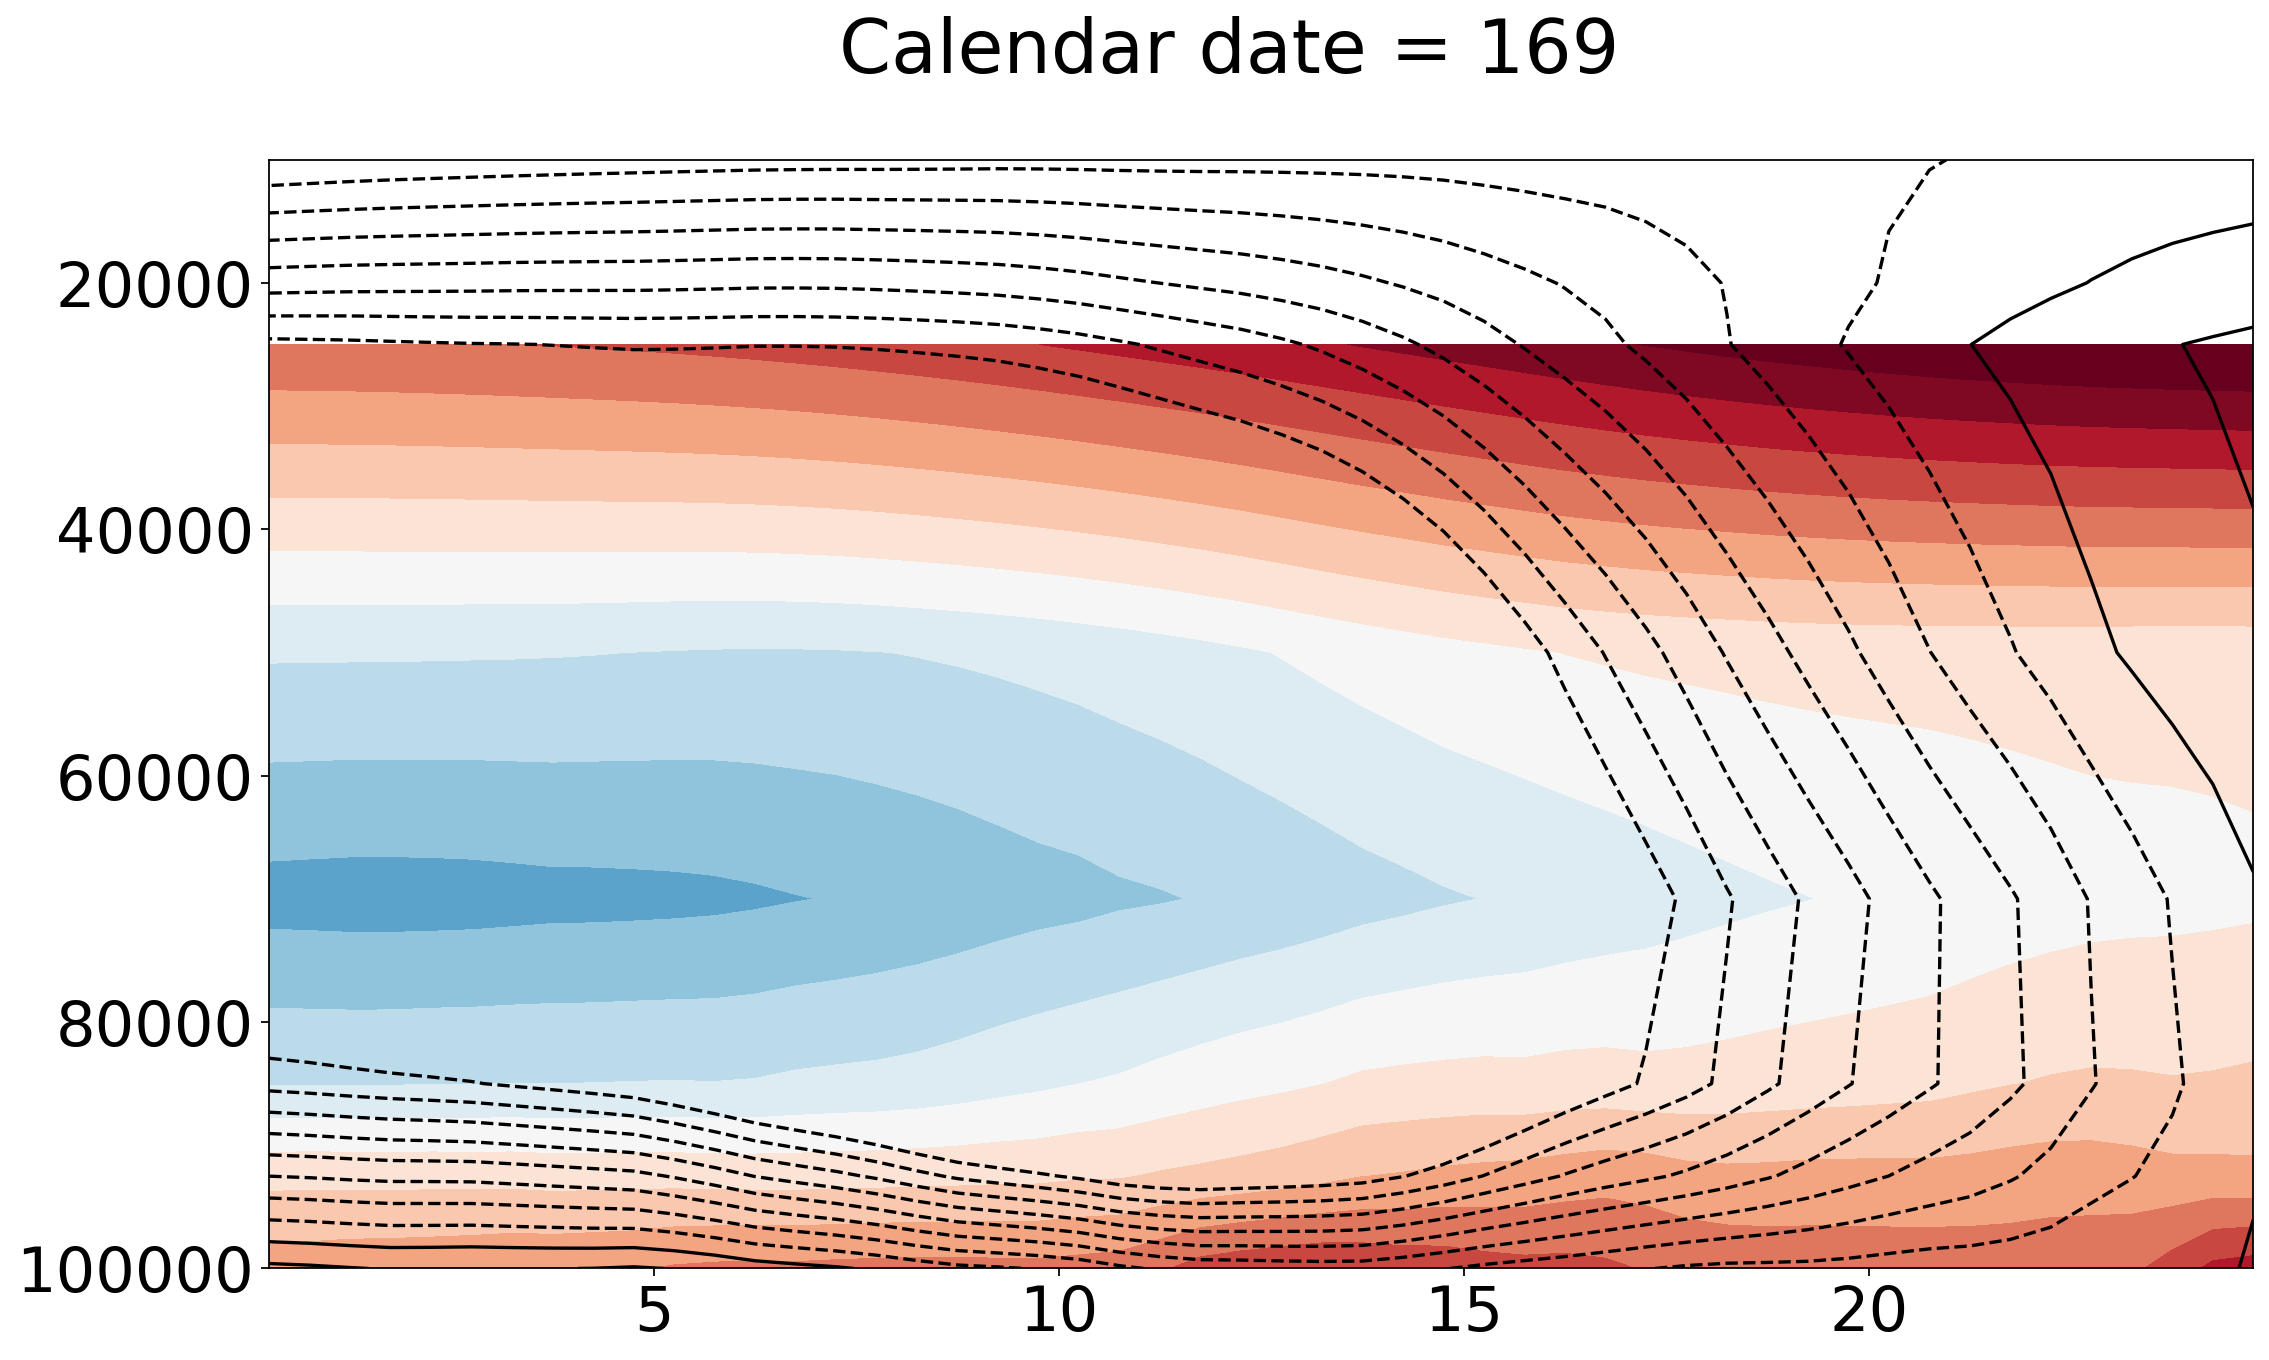

In [27]:
animation_object = equiv_theta_and_streamfunction_composites_animation_generator(
    equiv_theta_convolution,
    streamfunction_convolution,
    equiv_theta_grids,
    streamfunction_grids,
)
animation_object.save("animation.gif")

In [20]:
def get_MSE_vertical_flux(fname_MSE, fname_w):
    dataset_MSE = nc.Dataset(os.path.join(path_ERA5, fname_MSE))
    dataset_w = nc.Dataset(os.path.join(path_ERA5, fname_w))
    lon = dataset_MSE["lon"][:]
    lat = dataset_MSE["lat"][:]
    pressure = dataset_MSE["plev"][:]
    MSE = dataset_MSE["MSE"][:, :, :, :]
    w = dataset_w["w"][:, np.isin(dataset_w["plev"][:], dataset_MSE["plev"][:]), :, :]

    MSE_flux = np.multiply(MSE, w)

    MSE_flux_zonmean = np.mean(MSE_flux, axis=3)
    MSE_flux_convolution = moving_average(MSE_flux_zonmean, axis=0)

    MSE_flux_zonmean = MSE_flux_zonmean.reshape(
        -1, 365, MSE_flux_zonmean.shape[1], MSE_flux_zonmean.shape[2]
    )
    MSE_flux_convolution = MSE_flux_convolution.reshape(
        -1, 365, MSE_flux_convolution.shape[1], MSE_flux_convolution.shape[2]
    )

    return MSE_flux_zonmean, MSE_flux_convolution, (pressure, lat)

In [21]:
MSE_flux_raw, MSE_flux_convolution, MSE_flux_grids = get_MSE_vertical_flux(
    "indian_MSE.nc", "indian_w.nc"
)

In [24]:
def MSE_flux_cases_animation_generator(MSE_flux, lat, pressure):
    fig, axes = plt.subplots(
        nrows=2, ncols=5, figsize=(32, 18), dpi=160, sharex=True, sharey=True
    )
    plt.rcParams.update({"font.size": 28})

    def init():
        return None

    def run(index):
        for (i, j), ax in np.ndenumerate(axes):
            ax.cla()
            match i:
                case 0:
                    ax.invert_yaxis()
                    tmp_year = list(monsoon_onset_date.keys())[j]
                    tmp_date = list(monsoon_onset_date.values())[j]
                case 1:
                    tmp_year = list(monsoon_onset_date.keys())[j - 5]
                    tmp_date = list(monsoon_onset_date.values())[j - 5]
            tmp = MSE_flux[tmp_year - 1979, index + 100]
            ax.contourf(
                lat,
                pressure,
                tmp,
                levels=np.linspace(-2e4, 2e4, 16),
                extend="both",
                cmap="RdBu_r",
            )
            ax.contour(
                lat, pressure, tmp, levels=np.linspace(-2e4, 2e4, 16), colors="k"
            )

            ax.set_title(f"({tmp_year}, {tmp_date})")
        fig.suptitle(f"Calendar date = {index + 100}")
        return None

    ani = animation.FuncAnimation(fig, run, frames=70, interval=20, init_func=init)
    return ani


def MSE_flux_composites_animation_generator(MSE_flux, lat, pressure):
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(16, 9), dpi=160, sharex=True, sharey=True
    )
    plt.rcParams.update({"font.size": 28})

    def init():
        return None

    def run(index):
        for (i,), ax in np.ndenumerate(axes):
            ax.cla()
            match i:
                case 0:
                    ax.invert_yaxis()
                    tmp = np.mean(
                        MSE_flux[
                            np.array(list(monsoon_onset_date.keys())[:5]) - 1979,
                            index + 100,
                        ],
                        axis=0,
                    )
                    ax.set_title("Early onset")
                case 1:
                    tmp = np.mean(
                        MSE_flux[
                            np.array(list(monsoon_onset_date.keys())[-5:]) - 1979,
                            index + 100,
                        ],
                        axis=0,
                    )
                    ax.set_title("Late onset")
            ax.contourf(
                lat,
                pressure,
                tmp,
                levels=np.linspace(-2e4, 2e4, 16),
                extend="both",
                cmap="RdBu_r",
            )
            ax.contour(
                lat, pressure, tmp, levels=np.linspace(-2e4, 2e4, 16), colors="k"
            )
        fig.suptitle(f"Calendar date = {index + 100}")
        return None

    ani = animation.FuncAnimation(fig, run, frames=70, interval=100, init_func=init)
    return ani

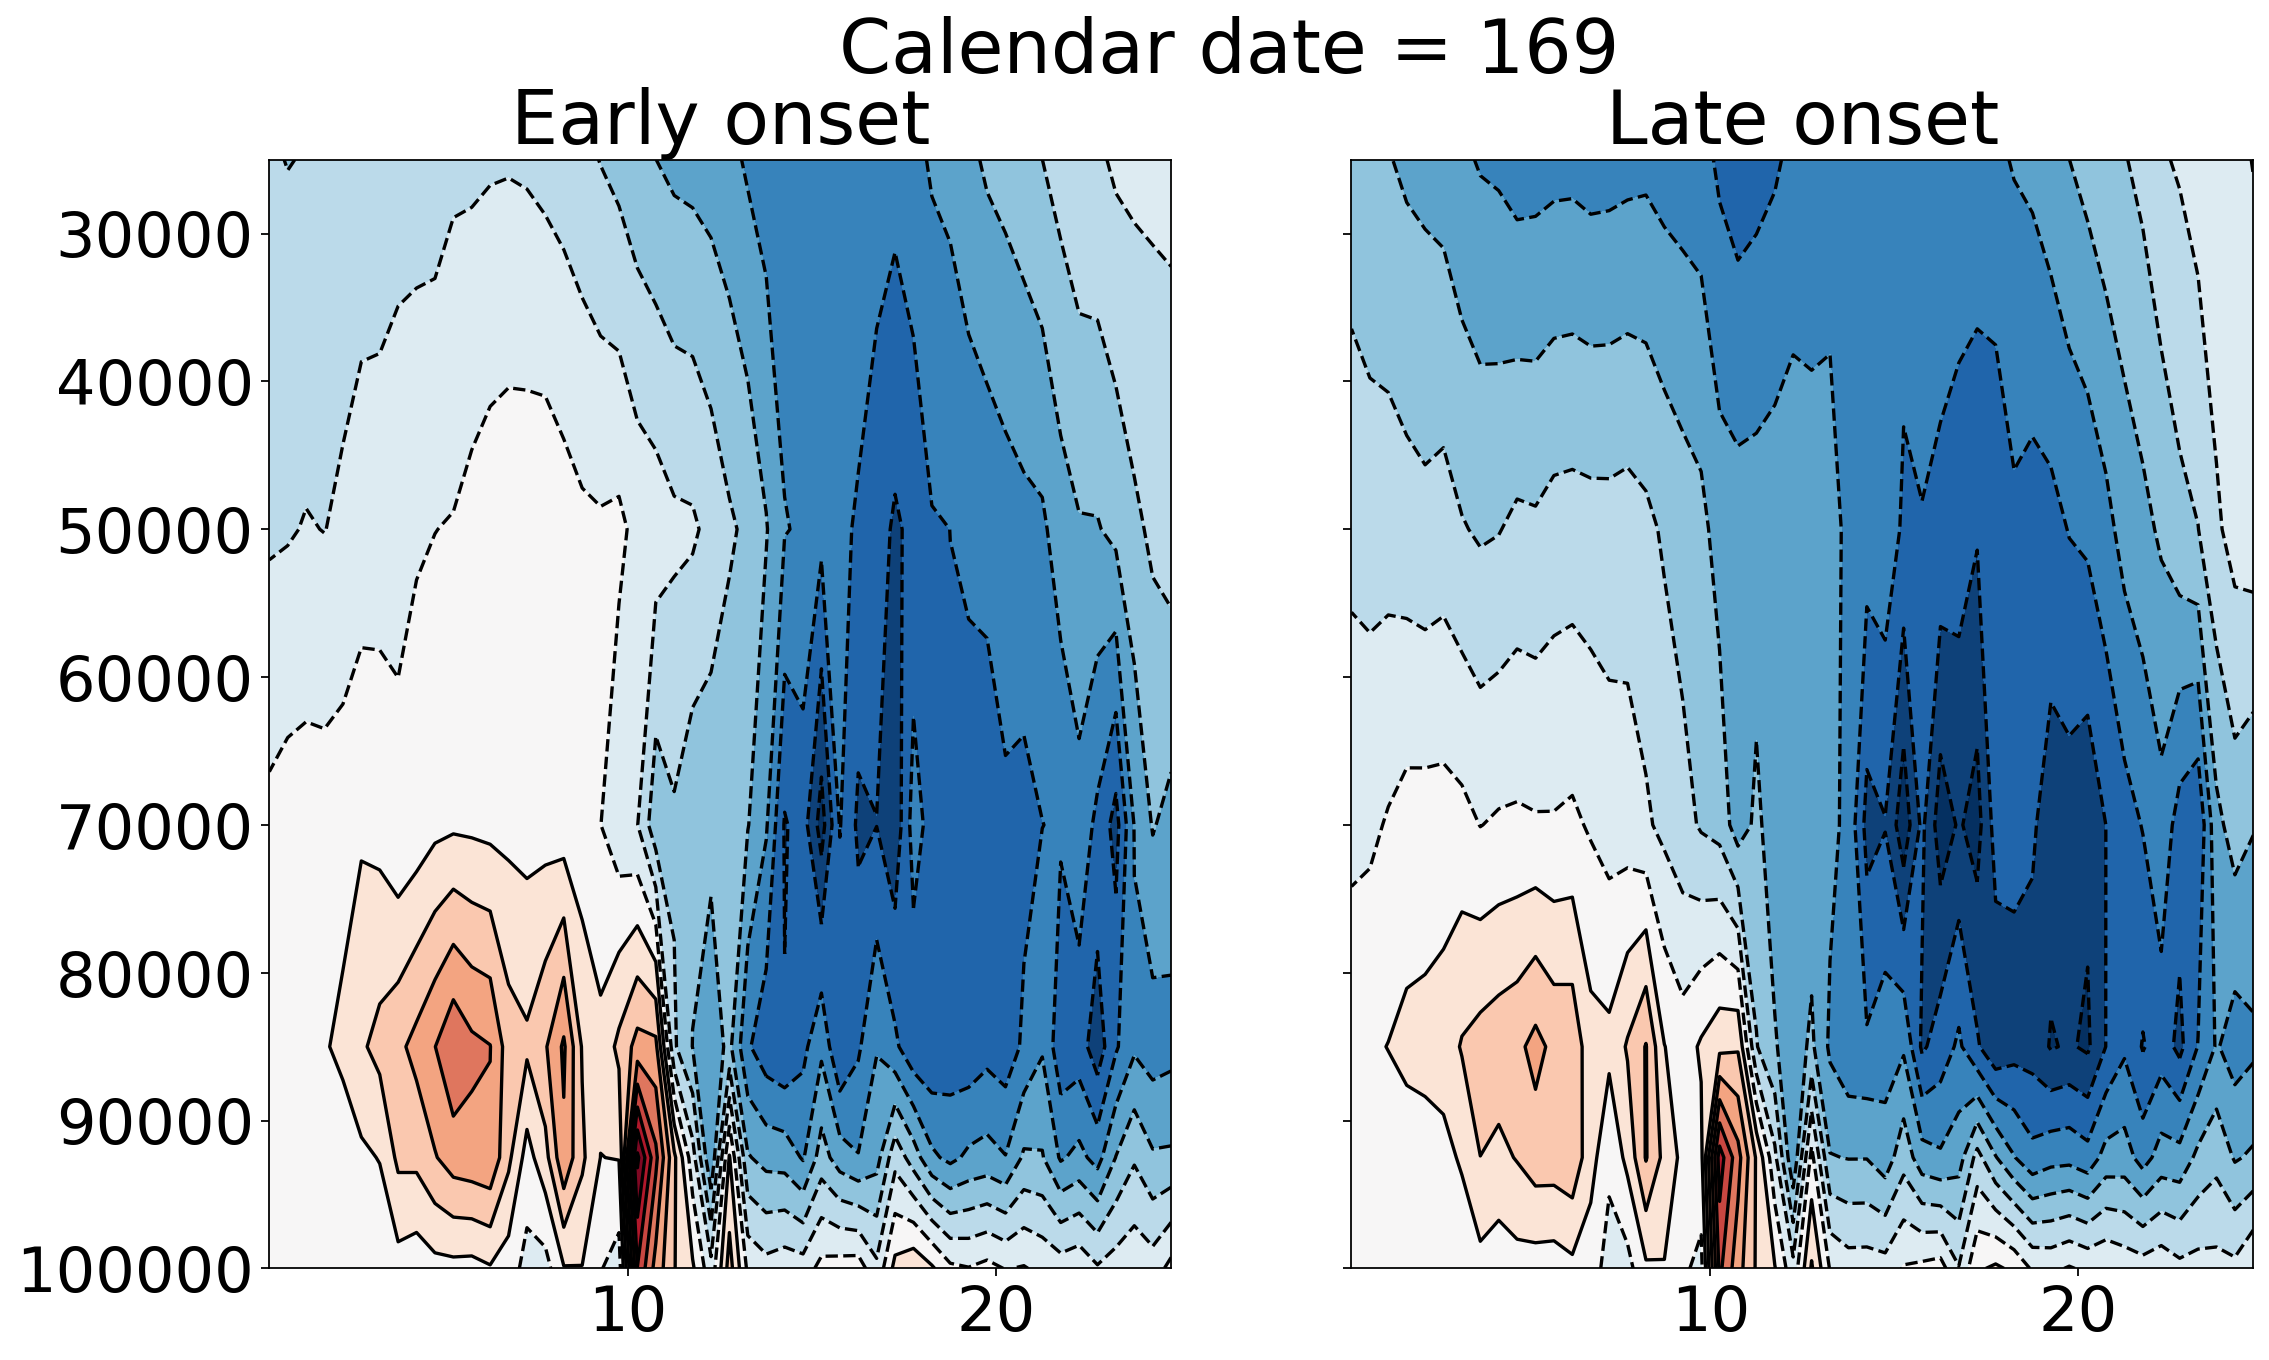

In [25]:
# animation_object = MSE_flux_cases_animation_generator(
#     MSE_flux_convolution, MSE_flux_grids[1], MSE_flux_grids[0]
# )
# animation_object.save("animation.gif")

animation_object = MSE_flux_composites_animation_generator(
    MSE_flux_convolution, MSE_flux_grids[1], MSE_flux_grids[0]
)
animation_object.save("animation.gif")